In [ ]:
import os
import pandas as pd
import re
import subprocess
import numpy as np


# -*- coding: utf-8 -*-
import sys
import random
import numpy as np
from tqdm import tqdm
import pickle

sys.path.append('../')
from pytorch.common.datasets_parsers.av_parser import AVDBParser

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pytorch.common.datasets_parsers.av_parser import AVDBParser
# from voice_feature_extraction import OpenSMILE
from accuracy import Accuracy, Accuracy_regression


(1120, 2269)
0:	learn: -1.9414797	total: 2.39s	remaining: 11m 54s
1:	learn: -1.9364516	total: 4.68s	remaining: 11m 37s
2:	learn: -1.9329816	total: 6.96s	remaining: 11m 28s
3:	learn: -1.9289709	total: 9.24s	remaining: 11m 23s
4:	learn: -1.9255953	total: 11.5s	remaining: 11m 16s
5:	learn: -1.9216082	total: 13.8s	remaining: 11m 13s
6:	learn: -1.9166055	total: 16.1s	remaining: 11m 13s
7:	learn: -1.9124525	total: 18.4s	remaining: 11m 11s
8:	learn: -1.9091193	total: 20.6s	remaining: 11m 7s
9:	learn: -1.9050107	total: 22.9s	remaining: 11m 4s
10:	learn: -1.9003416	total: 25.2s	remaining: 11m 1s
11:	learn: -1.8967048	total: 27.4s	remaining: 10m 57s
12:	learn: -1.8935589	total: 29.6s	remaining: 10m 53s
13:	learn: -1.8903746	total: 31.9s	remaining: 10m 50s
14:	learn: -1.8873313	total: 34.1s	remaining: 10m 48s
15:	learn: -1.8830515	total: 36.5s	remaining: 10m 47s
16:	learn: -1.8794597	total: 38.8s	remaining: 10m 45s
17:	learn: -1.8760844	total: 41.1s	remaining: 10m 43s
18:	learn: -1.8733454	total:

C:\moc\IPM\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 7
  .format(len(labels), len(target_names))
C:\moc\IPM\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\moc\IPM\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         0
          4       0.00      0.00      0.00        32
          5       0.10      0.09      0.10        32
          6       0.00      0.00      0.00        32
          7       0.08      0.09      0.08        32
          8       0.02      0.03      0.02        32

avg / total       0.03      0.03      0.03       224

Confusion matrix
 [[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [29  1  0  0  0  1  1  0  0]
 [ 5  8  0  3  0  4 12  0  0]
 [15  0  6  2  0  4  5  0  0]
 [ 0  2  3 20  1  3  3  0  0]
 [ 2  6  1  5  9  8  1  0  0]
 [ 0  1  1  0  0 19 11  0  0]
 [ 3  1  0  1  0  0 27  0  0]]


C:\Users\ipmstud\Desktop\mlschool\code\audio_feature_classification\accuracy.py:31: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
 [[ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [0.91 0.03 0.   0.   0.   0.03 0.03 0.   0.  ]
 [0.16 0.25 0.   0.09 0.   0.12 0.38 0.   0.  ]
 [0.47 0.   0.19 0.06 0.   0.12 0.16 0.   0.  ]
 [0.   0.06 0.09 0.62 0.03 0.09 0.09 0.   0.  ]
 [0.06 0.19 0.03 0.16 0.28 0.25 0.03 0.   0.  ]
 [0.   0.03 0.03 0.   0.   0.59 0.34 0.   0.  ]
 [0.09 0.03 0.   0.03 0.   0.   0.84 0.   0.  ]]


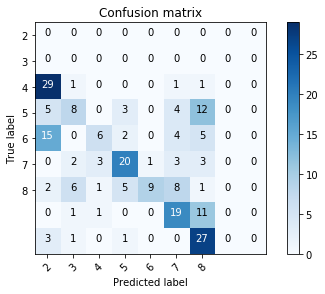

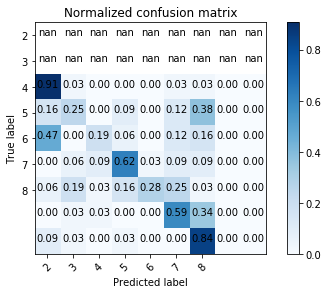

In [11]:
def get_data(dataset_root, file_list, max_num_clips=0):
    dataset_parser = AVDBParser(dataset_root, file_list,
                                max_num_clips=max_num_clips)
    data = dataset_parser.get_data()
    print('clips count:', len(data))
    print('frames count:', dataset_parser.get_dataset_size())
    return data

def calc_features(data, opensmile_root_dir, opensmile_config_path):
    vfe = OpenSMILE(opensmile_root_dir, opensmile_config_path)

    progresser = tqdm(iterable=range(0, len(data)),
                      desc='calc audio features',
                      total=len(data),
                      unit='files')

    feat, targets = [], []
    for i in progresser:
        clip = data[i]

        try:
            voice_feat = vfe.process(clip.wav_rel_path)
        except:
            print('error calc voice features!')
            data.remove(clip)
            continue

        feat.append(voice_feat)
        targets.append(clip.labels)

    print('feat count:', len(feat))
    return np.asarray(feat, dtype=np.float32), np.asarray(targets, dtype=np.float32)

def classification(X_train, X_test, y_train, y_test, accuracy_fn, pca_dim=100, C=1.5):
    if pca_dim > 0:
        pca_model = PCA(n_components=min(pca_dim, X_train.shape[1])).fit(X_train)
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)
        
    print (X_train.shape)
    
#     print (np.cumsum(PCA().fit(X_train).explained_variance_ratio_)[:100])

    # shuffle
    combined = list(zip(X_train, y_train))    
    random.shuffle(combined)
    X_train[:], y_train[:] = zip(*combined)
    
    scaler = StandardScaler().fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    # TODO: используйте классификаторы из sklearn
#     model = RandomForestClassifier(n_estimators=1000, max_depth=4, n_jobs=-1)
# #     model = CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=3, loss_function="MultiClass")
    ##model = svm.SVC(C=C)  
    model = CatBoostClassifier(iterations=300, loss_function="MultiClass")
#     model2 = LogisticRegression(C=C) 
#     model = RandomForestClassifier(n_estimators=200, max_depth=2)

#     model = RandomForestClassifier(n_estimators=1000,max_depth=3, n_jobs=-1)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
#     model0.fit(X_train,y_train)    
#     model1.fit(X_train,y_train)
#     y_pred_prob0 = model0.predict_proba(X_train)
#     y_pred_prob1 = model1.predict_proba(X_train)    
#     model.fit(np.hstack((y_pred_prob0,y_pred_prob1)),y_train) 

#     y_pred_prob0 = model0.predict_proba(X_test)
#     y_pred_prob1 = model1.predict_proba(X_test)    
#     y_pred = model.predict(np.hstack((y_pred_prob0,y_pred_prob1)))
    
    accuracy_fn.by_clips(y_pred)
    
    return (model)

if __name__ == "__main__":
    experiment_name = 'avec2013'
    max_num_clips = 0 # загружайте только часть данных для отладки кода
    use_dump = True # используйте dump для быстрой загрузки рассчитанных фич из файла

    # dataset dir
    base_dir = 'D:/AVER'
    if 1:
        train_dataset_root = r'C:\Users\ipmstud\Desktop\mlschool\ryerson\Video'
        train_file_list = r'C:\Users\ipmstud\Desktop\mlschool\ryerson\train_data_with_landmarks.txt'
        test_dataset_root = r'C:\Users\ipmstud\Desktop\mlschool\ryerson\Video'
        test_file_list = r'C:\Users\ipmstud\Desktop\mlschool\ryerson\test_data_with_landmarks.txt'
    elif 1:
        train_dataset_root = r'C:/Users/ipmstud/Desktop/mlschool/OMG-Emotion\omg_TrainVideos\preproc\frames'
        train_file_list = r'C:/Users/ipmstud/Desktop/mlschool/OMG-Emotion\omg_TrainVideos\preproc\train_data_with_landmarks.txt'
        test_dataset_root =r'C:/Users/ipmstud/Desktop/mlschool/OMG-Emotion\omg_TrainVideos\preproc\frames'
        test_file_list = r'C:/Users/ipmstud/Desktop/mlschool/OMG-Emotion\omg_TrainVideos\preproc\valid_data_with_landmarks.txt'

    # opensmile configuration
    opensmile_root_dir = r'C:/Users/ipmstud/Desktop/mlschool/code/audio_feature_classification/opensmile-2.3.0'
    # TODO: поэкспериментируйте с различными конфигурационными файлами библиотеки OpenSmile
    opensmile_config_path = 'opensmile-2.3.0/config/PLP_0_D_A.conf'
    
    #features = ['avec2013', 'ComParE_2016', 'IS09_emotion']
    features = ['avec2013']
    
    models = []
    if not use_dump:
        # load dataset
        train_data = get_data(train_dataset_root, train_file_list, max_num_clips=max_num_clips)
        test_data = get_data(test_dataset_root, test_file_list, max_num_clips=max_num_clips)

        # get features
        train_feat, train_targets = calc_features(train_data, opensmile_root_dir, opensmile_config_path)
        test_feat, test_targets = calc_features(test_data, opensmile_root_dir, opensmile_config_path)

        accuracy_fn = Accuracy(test_data, experiment_name=experiment_name)

        with open(experiment_name + '.pickle', 'wb') as f:
            pickle.dump([train_feat, train_targets, test_feat, test_targets, accuracy_fn], f, protocol=2)
    else:
        for i in [1]:
            for experiment_name in features:
                with open(experiment_name + '.pickle', 'rb') as f:
                    train_feat, train_targets, test_feat, test_targets, accuracy_fn = pickle.load(f)
                    models.append(classification(train_feat, test_feat, train_targets, test_targets, accuracy_fn=accuracy_fn, pca_dim=0, C=i))

# run classifiers

#     classification(train_feat, test_feat, train_targets, test_targets, accuracy_fn=accuracy_fn, pca_dim=0, C=i)

    

In [ ]:
    #features = ['avec2013', 'ComParE_2016', 'IS09_emotion']
    features = ['avec2013']
    
    models = []
    if not use_dump:
        # load dataset
        train_data = get_data(train_dataset_root, train_file_list, max_num_clips=max_num_clips)
        test_data = get_data(test_dataset_root, test_file_list, max_num_clips=max_num_clips)

        # get features
        train_feat, train_targets = calc_features(train_data, opensmile_root_dir, opensmile_config_path)
        test_feat, test_targets = calc_features(test_data, opensmile_root_dir, opensmile_config_path)

        accuracy_fn = Accuracy(test_data, experiment_name=experiment_name)

        with open(experiment_name + '.pickle', 'wb') as f:
            pickle.dump([train_feat, train_targets, test_feat, test_targets, accuracy_fn], f, protocol=2)
    else:
        for i in [1,1,1, 1.5, 1.5, 1,5,2,2,2]:
            for experiment_name in features:
                with open(experiment_name + '.pickle', 'rb') as f:
                    train_feat, train_targets, test_feat, test_targets, accuracy_fn = pickle.load(f)
                    models.append(classification(train_feat, test_feat, train_targets, test_targets, accuracy_fn=accuracy_fn, pca_dim=0, C=i))

# run classifiers

In [ ]:
 np.logspace(-3,+3,10)

In [9]:
from catboost import CatBoostClassifier

In [ ]:

with open('avec2013'+ '.pickle', 'wb') as f:
    pickle.dump([train_feat, train_targets, test_feat, test_targets, accuracy_fn], f, protocol=2)

models.append(classification(train_feat, test_feat, train_targets, test_targets, accuracy_fn=accuracy_fn, pca_dim=0, C=i))

rs = 7 , IS09_emotion
